# Predicting Inspection Results
---

## Objectives

- I am tackling a binary classification problem involving restaurant health inspections using the data I processed in `01_EDA`.
- The two classes I am trying to predict will be Pass/Fail.
- I will aim to optimize my model for **recall** (*AKA sensitivity or true positive rate*) since missing a positive case (inspection failure) could have significant consequences, akin to missing a diagnosis or not detecting a dangerous item going through a metal detector.

---

### Imports

In [26]:
import ast # for evaluating violation codes column properly

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve)

In [28]:
# Setting pandas to display all columns.
pd.set_option('display.max_columns', None)

---
### Load Dataset

In [31]:
file_path = '../../data/processed_chicago.csv'

In [33]:
chicago = pd.read_csv('../../data/processed_chicago.csv')
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection,average_severity
0,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,Pass,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False,0.000000
1,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True,4.285714
2,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False,3.500000


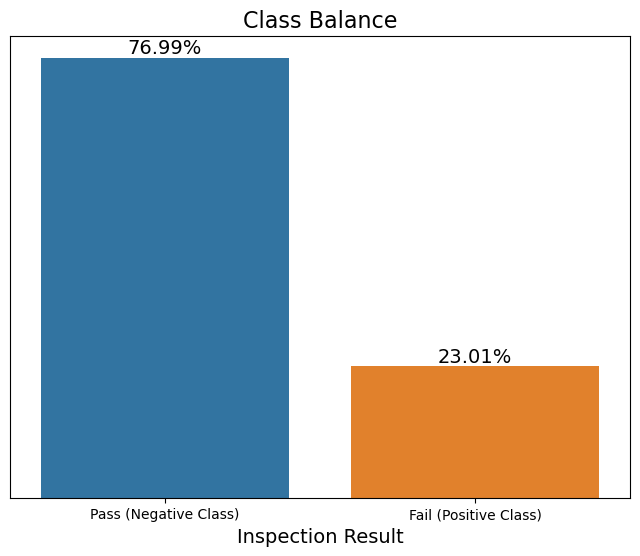

In [34]:
# Baseline Accuracy (as bar chart)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x = ['Pass (Negative Class)', 'Fail (Positive Class)'],
                 y = chicago['results'].value_counts().values,
                 hue = chicago['results'].value_counts().index,
                 legend = False)
# Annotated bars
for i, val in enumerate(chicago['results'].value_counts().values):
    count_norm = chicago['results'].value_counts(normalize=True)[i]
    ax.text(i, val + 0.1,
            f"{count_norm:.2%}",
            ha = 'center',
            va = 'bottom',
            fontsize = 14)
    
plt.title("Class Balance", fontsize=16)
plt.xlabel("Inspection Result", fontsize=14)
plt.yticks([], []); # to remove y tick values

---
- I have chosen `Fail` as our positive class because our features are health codes which were broken, so it would make more intuitive sense to have my coefficients be interpretable as *'Breaking this code makes you this % more likely to fail'* in order to place emphasis on the major health codes to avoid breaking.

---
# Defining Functions

In [54]:
def evaluate_model(model, X_test, y_test, threshold = 0.5):
    '''
    TBD
    '''
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label = 1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label = 1, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, pos_label = 1, zero_division=0)
    }
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label = 1)
    auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, label = f'ROC Curve (AUC = {auc:.2f})', color = 'blue', linewidth = 2)
    axes[0].plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc = 'lower right')

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels = [1, 0])
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Fail', 'Pass'], yticklabels = ['Fail', 'Pass'],
                cbar = False, ax = axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show();

    return metrics

In [56]:
def get_odds(model):
    '''
    TBD
    '''
    features = model.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model.named_steps['classifier'].coef_.flatten()
    
    coeff_df = pd.DataFrame({
        'Feature': features,
        'Odds': np.exp(coefficients)
    }).sort_values(by = 'Odds', ascending = False)
    
    # Filter to only show violation codes as that's what I'd like to interpret
    coeff_df = coeff_df[coeff_df['Feature'].str.contains('violation_code')]
    # Clean up names a bit
    coeff_df['Feature'] = coeff_df['Feature'].str.replace('remainder__', '')

    return coeff_df

In [95]:
# Instantiating DataFrame to store all results in order to be compared upon later
model_results = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

---
### Preprocessing

In [40]:
# Encoding class labels (Pass = 0, Fail = 1)
chicago['results'] = chicago['results'].map({'Pass': 0, 'Fail': 1})
chicago['results'].value_counts(normalize = True)

results
0    0.769921
1    0.230079
Name: proportion, dtype: float64

In [42]:
# The cleanest solution I've found to handle the violation_codes column getting treated as a string.
chicago['violation_codes'] = chicago['violation_codes'].apply(ast.literal_eval)

# Flatten and get all unique violation codes
unique_codes = sorted(set(code for codes in chicago['violation_codes'] for code in codes))

# Hard coding one-hot encoded columns
for code in unique_codes:
    column_name = f"violation_code_{code}"
    chicago[column_name] = chicago['violation_codes'].apply(lambda x: 1 if code in x else 0)

chicago.shape

(61705, 82)

In [44]:
# Checking codes were properly encoded
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection,average_severity,violation_code_1,violation_code_2,violation_code_3,violation_code_4,violation_code_5,violation_code_6,violation_code_7,violation_code_8,violation_code_9,violation_code_10,violation_code_11,violation_code_12,violation_code_13,violation_code_14,violation_code_15,violation_code_16,violation_code_17,violation_code_18,violation_code_19,violation_code_20,violation_code_21,violation_code_22,violation_code_23,violation_code_24,violation_code_25,violation_code_26,violation_code_27,violation_code_28,violation_code_29,violation_code_30,violation_code_31,violation_code_32,violation_code_33,violation_code_34,violation_code_35,violation_code_36,violation_code_37,violation_code_38,violation_code_39,violation_code_40,violation_code_41,violation_code_42,violation_code_43,violation_code_44,violation_code_45,violation_code_46,violation_code_47,violation_code_48,violation_code_49,violation_code_50,violation_code_51,violation_code_52,violation_code_53,violation_code_54,violation_code_55,violation_code_56,violation_code_57,violation_code_58,violation_code_59,violation_code_60,violation_code_61,violation_code_62,violation_code_63,violation_code_64
0,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,0,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,0,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True,4.285714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,1,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False,3.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [46]:
# Ordinal encoding for risk
risk_mapping = {'Risk 1 (High)': 3, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 1}
chicago['risk'] = chicago['risk'].map(risk_mapping)
chicago['risk']

0        3
1        2
2        2
3        3
4        3
        ..
61700    2
61701    2
61702    3
61703    3
61704    2
Name: risk, Length: 61705, dtype: int64

In [48]:
# Creating X and y
X = chicago.drop(columns=['inspection_id', 'dba_name', 'aka_name', 'license', 'facility_type', 'address', 'inspection_date', 'results',
       'violations', 'name_cleaned', 'violation_codes', 'severity_levels'])
y = chicago['results']

In [50]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [52]:
# Since one-hot encoding and ordinal encoding are already applied, only scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), ['num_inspections', 'violation_count', 'average_severity']),
        ('ohe', OneHotEncoder(), ['inspection_type'])
    ],
    remainder='passthrough'  # Keep the already preprocessed columns as they are
)

---
# Iteration 1

### Modelling

In [62]:
# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000, random_state = 42))
])

In [64]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__C': [.001, .01, .1, 1, 10, 100, 1000],
    'classifier__penalty': ['l2', None],
    'classifier__solver': ['saga', 'lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'recall', verbose = 1, n_jobs = -1)
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


---
### Model Evaluation

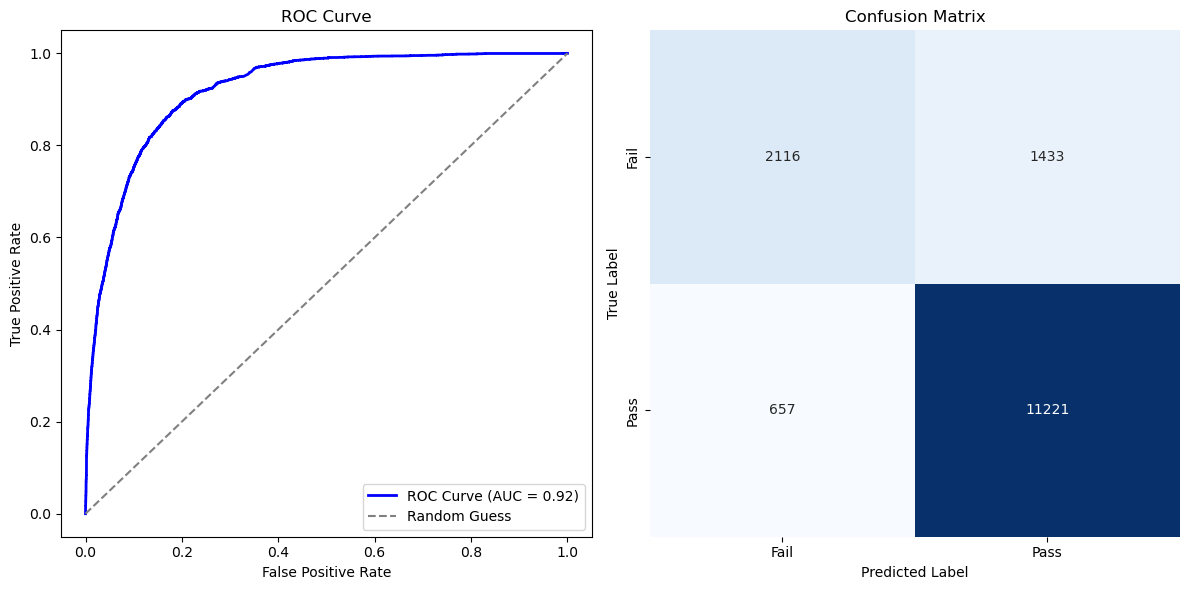

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.864523,0.763072,0.596224,0.669408


In [97]:
# Evaluation
model_results.loc['First_Iteration_LR'] = evaluate_model(model, X_test, y_test) # default threshold of 0.5
model_results

---
### Interpretations

I must address the assumptions I could be breaking before interpreting these coefficients.

**For example:**

- Independent Observations: Since our dataset could have multiple inspections for a single restaurant, this could mean our observations are not independent of each other. For example, a restaurant re-inspection would be related to the first inspection in terms of what violations (our explanatory variable) are being examined.

- On a similar note, multicollinearity must be happening in our violations as they are inherently grouped by category (Physical Facilities, Prevention of Food Contamination, Employee Health, etc.). For example, if a restaurant is cited for improper reheating procedures (Health Code 19), the common demoninator here is an unawareness of proper temperature control which means they are likely to also not be following proper cooling procedures (Health Code 20).

In [72]:
coeffs = get_odds(model)

# 10 Violation Codes with highest odds for failed inspection according to my model
coeffs.head(10)

,Feature,Odds
71,violation_code_59,263.571265
72,violation_code_60,13.763293
50,violation_code_38,12.946040
62,violation_code_50,9.962649
60,violation_code_48,5.593051
66,violation_code_54,4.633910
37,violation_code_25,3.236711
64,violation_code_52,2.998492
28,violation_code_16,2.732020
36,violation_code_24,2.385441


**Violation Code 59:** *Previous priority foundation violation corrected*

- "Priority violations create an immediate health hazard that carry a high-risk of causing food-borne illness. Priority violations must be corrected immediately; if they cannot be corrected immediately, the license will be suspended, and the food establishment must close" [source](https://www.chicago.gov/city/en/depts/cdph/provdrs/food_safety/svcs/understand_healthcoderequirementsforfoodestablishments.html)

- My model is able to recognize one of the major reasons for failing an inspection which is a good sign.

**Violation Code 38:** *Insects, rodents, & animals not present*
- A restaurant is 12.9 times more likely to fail if there are rodents present according to my model.

---
## Conclusion

- A suprisingly high accuracy for our first iteration of modelling. However I am not impressed with the amount of false negatives.
- In my second model I need to consider different methods for ensuring I can achieve higher recall than my first iteration, as ~60% is too low.
- For my second iteration I have introduced the threshold argument to my `evaluate_model` function and for further control of my model so hopefully I can find the sweet spot there.

---

# Iteration 2

### Modelling

In [104]:
# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000, random_state = 42))
])

In [118]:
# Moving forward with saga solver and l2 loss function that was chosen by first gridsearch, fine tuning most optimal alpha
param_grid = {
    'classifier__C': [9, 9.5, 10, 10.5, 11],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['saga'] 
}

grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'recall', verbose = 1, n_jobs = -1)
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'classifier__C': 9, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


---
### Model Evaluation

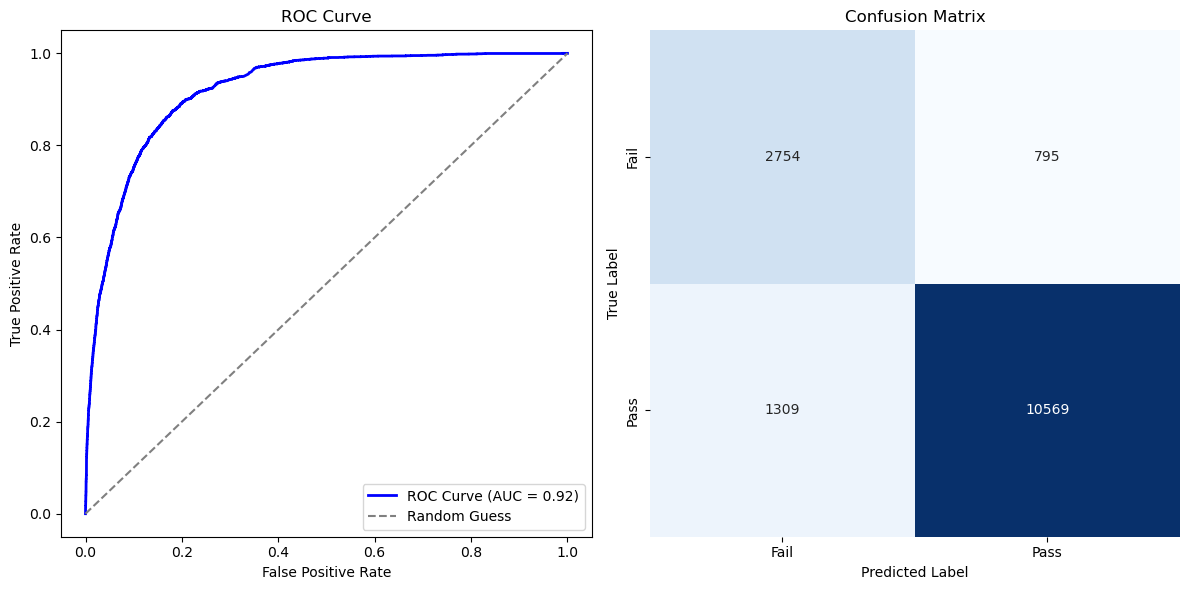

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.864523,0.763072,0.596224,0.669408
Second_Iteration_LR,0.863616,0.677824,0.775993,0.723594


In [124]:
# Evaluation
model_results.loc['Second_Iteration_LR'] = evaluate_model(model, X_test, y_test, threshold = 0.3) # changing threshold in hopes of improving recall
model_results

---
### First vs Second Iteration

---
### Conclusion


---